<font size="5">**NEURAL NETWORK**</font>

**PRE-PROCESSING STEPS**

The following cell has steps involving importing of necessary libraries and also defining functions for pre-processing steps such as removal of emojis, punctuations from the reviews. Also, function for removal of stopwords along with the function for lemmatization.
Next step involves reading the csv and storing it in the dataframe.

In [1]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import nltk
import re
import pickle

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

import emoji
lemmatizer = WordNetLemmatizer()

#Pre-processing functions

def remove_emoji(string):
    return emoji.replace_emoji(string, '')


def stop_word_list():
    nltk.download('stopwords')
    #Getting stopwords
    sw = stopwords.words('english')

    #Removing the important stopwords from the corpus
    sw.remove('not')
    sw.remove("didn't")
    sw.remove("don't")
    sw.remove("wasn't")

    return sw

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

#Reading CSV
df = pd.read_csv(r'Labelled_Dataset.csv')

df.columns = ['LABEL','COMMENTS']

#Removing unnecessary spaces from the labels
labels = df['LABEL'].tolist()
labels = [label.strip() for label in labels]
df['LABEL'] = labels

**SPLITTING DATA**

The next cell has a function of splitting the data into train and test set. The size of training set is 80% of the total dataset whereas the rest of the 20% of the whole dataset makes up the test set. The random state parameter is used and set to a constant integer, in this case 42, to make the splitting of data deterministic and reproducible.

In [2]:
# Function for splitting of data 

def Split_data(x,y):
    
    #Importing the necessary library
    from sklearn.model_selection import train_test_split
    
    df_train,df_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
    return(df_train,df_test,y_train,y_test)

**CONFUSION MATRIX**

The following function will create the confusion matrix and will also give precision, recall and f1 score.

In [3]:
#Confusion Matrix

def Create_Confusion_Matrix(model, df_test, y_test):
    
    #Importing necessary libraries
    
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    
    #Getting predicted classes and actual classes
    
    predicted_classes = model.predict(df_test)
    classes_x=np.argmax(predicted_classes,axis=1)
    y_true = y_test

    #Printing the precision,recall and F1 metrics 
    
    print(metrics.classification_report(y_true, classes_x, digits=3))
    
    #Constructing the confusion matrix
    
    labels = ['Negative', 'Neutral', 'Positive']
    cm = confusion_matrix(y_true, classes_x)
    plt.figure(figsize = (5, 5))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    ax.xaxis.set_ticklabels(labels);
    ax.yaxis.set_ticklabels(labels);
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    print(cm)

**MODEL**

The Neural Network used consists of a input layer, one hidden layer and a output layer. Input and hidden layer both have 120 units. The activation function used in input and hidden layer is ReLu and Softmax activation function is used in the output layer. 40-60 epochs were yielding similar results and as we increased the epochs beyond 60 the test accuracy was decreasing because of overfitting.
Seeding was used to make the model reproducible as without seeding the model was getting trained differently with each run. The count vectorizer was used as the tf-idf vectorizer was yielding less accuracy. The reason for count vectorizer doing better in our case is data length is short and with less unique words.

In [4]:
#Function for creating a model

def Neural_Network_Model(df_train,df_test,y_train,y_test,x,y):
    
    #Importing necessary libraries
    
    import tensorflow as tf
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.preprocessing import LabelEncoder
    import keras
    from numpy.random import seed
    import random as rn
    import os
    
    #Seeding
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(37)
    rn.seed(1254)
    tf.random.set_seed(89)

    vectorizer = CountVectorizer()
    vectorizer.fit(x)

    df_train = vectorizer.transform(df_train)
    df_test = vectorizer.transform(df_test)

    le = LabelEncoder()
    le.fit(y)

    y_train = le.transform(y_train)
    y_test = le.transform(y_test)

    # Save the CountVectorizer
    with open('count_vectorizer.pickle', 'wb') as handle:
        pickle.dump(vectorizer, handle)

    # Save the LabelEncoder
    with open('label_encoder.pickle', 'wb') as handle:
        pickle.dump(le, handle)

    model = keras.Sequential()
    
    #Input layer
    
    model.add(keras.layers.Dense(units=120, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
    
    #Hidden layer
    
    model.add(keras.layers.Dense(units=120, activation='relu', input_dim=120))
    
    #Output layer
    
    model.add(keras.layers.Dense(units=3, activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #Training the model
    history = model.fit(df_train, y_train, 
              epochs=40, verbose=0)
    scores = model.evaluate(df_test, y_test, verbose=1)
    print("Accuracy:", scores[1])
    Create_Confusion_Matrix(model, df_test, y_test)

    return(model)

**FIRST CASE: EMOJI REMOVAL**

In this case, we just removed the emojis from the comment, split the processed dataset and trained the neural network. After training the model with emojiless data the test accuracy came out to be around 83.33%. 

In [5]:
#Removing emoji

for items in range(0,df.shape[0]):
    df.at[items, 'CLEAN COMMENTS']= remove_emoji(df.at[items, 'COMMENTS'])

**SIXTH CASE: STOP WORD REMOVAL WITH LEMMATISATION**

In this case, we applied lemmatisation on the data used for the above(fifth) case, split the processed dataset and trained the neural network. After training the model with this data the test accuracy came out to be around 84.58%.  

In [6]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

#Creating Tokens
df['TOKEN'] = df['CLEAN COMMENTS'].apply(word_tokenize)

#PoS Tagging
nltk.download('omw-1.4')
df['POS TAGGING'] = df['TOKEN'].apply(nltk.pos_tag)
for items in range(0,df.shape[0]):
    df.at[items, 'POS TAGGING'] = list(map(lambda x: (x[0], pos_tagger(x[1])),df.at[items, 'POS TAGGING']))

#Lemmatization
for items in range(0,df.shape[0]):
    df.at[items,'LEMM'] = lemmatize(df.at[items,'POS TAGGING'])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Meghna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Meghna\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Meghna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Meghna\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


c:\Users\Meghna\Sentiment-Analysis-AI\SentimentAnalysis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8248 - loss: 1.1561  
Accuracy: 0.8333333134651184
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0      0.908     0.884     0.896       112
           1      0.576     0.559     0.567        34
           2      0.837     0.872     0.854        94

    accuracy                          0.833       240
   macro avg      0.774     0.772     0.772       240
weighted avg      0.833     0.833     0.833       240

[[99  6  7]
 [ 6 19  9]
 [ 4  8 82]]


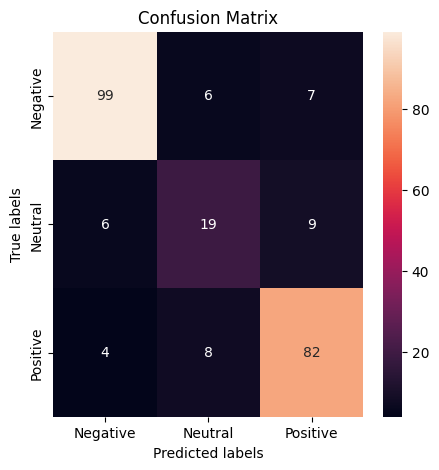

In [7]:
df_train,df_test,y_train,y_test = Split_data(df['LEMM'],df['LABEL'])
model = Neural_Network_Model(df_train,df_test,y_train,y_test,x=df['LEMM'],y=df['LABEL'])

In [8]:
model.save('sentiment_model.h5')